In [1]:
# default_exp data.core_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [4]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

## Normalize

### old

In [92]:
# export
import warnings
class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, to_norm=['TensorCon','TensorSeqs'], verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean,to_norm')
        self.m, self.s = {}, {}
        warnings.warn("NormalizeTSMulti is depricated. Please use `NormalizeSeqsMulti`")

    def encodes(self, o):
        for i in range(len(o)-1):
            self.m[i], self.s[i] = 0, 1
            if type(o[i]) == TensorCon and o[i].shape[-1]>0: # if tensor has shape (bs,0) than ignore
                if 'TensorCon' in self.to_norm:
                    self.m[i] = torch.mean(o[i])
                    self.s[i] = torch.std(o[i]) + self.eps 
            elif type(o[i]) == TensorSeqs:
                if 'TensorSeqs' in self.to_norm:
                    self.m[i] = torch.mean(o[i], -1, keepdim=True)
                    self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                    self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            elif self.verbose:
                if o[i].shape[-1]>0 and not type(o[i]) == TensorCatI:
                    print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0] 
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        
        return TSMulti_([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])       
    
    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return TSMulti_([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

### new

In [93]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [6]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [47]:
a = TensorSeqs(np.arange(12))
a = (a-2)*2.5
a

TensorSeqs([-5.0000, -2.5000,  0.0000,  2.5000,  5.0000,  7.5000, 10.0000, 12.5000,
        15.0000, 17.5000, 20.0000, 22.5000])

In [85]:
# export
class NormalizeSeqs(Transform):
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = 0, 1
        
    def to_same_device(self, o):    
        if o.is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
        else:
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)     
            
    def encodes(self, o: TensorSeqs):
        self.m = torch.mean(o, -1, keepdim=True)
        self.s = torch.std(o,  -1, keepdim=True) +self.eps
        self.s = _zeros_2_ones(self.s, self.eps*10)
        if self.verbose:
            print('encodes',[a.shape for a in o],
                  'm shape', {k:o.shape for k,o in self.m.items()},
                  's shape',{k:o.shape for k,o in self.s.items()})
        
        return self.norm(o)
    
    def norm(self, o):
        return (o-self.m) / self.s
        
    def decodes(self, o: TensorSeqs):
        if self.verbose:
            print('decodes',o.shape,  
                  'm shape',self.m.shape,
                  's shape',self.s.shape)
        return self.denorm(o)
    
    def denorm(self, o):
        self.to_same_device(o)
        return (o*self.s)+self.m 

In [86]:
tmf = NormalizeSeqs()
o = TensorSeqs(np.arange(12.))
o_tmf = tmf(o)
test_eq(tmf.decode(o_tmf),TensorSeqs(np.arange(12.)))

In [97]:
# export
class NormalizeSeqsMulti(ItemTransform):
    """A shell Transformer to normalize `TensorSeqs` inside `TSMulti_` with `NormalizeSeqs`. """
    @delegates(NormalizeSeqs.__init__)
    def __init__(self, n_its=4, **kwargs):
        """`n_its` does not include the ts to predict."""
        self.f = {i:NormalizeSeqs(**kwargs) for i in range(n_its)}
        
    def encodes(self, o:TSMulti_):
        r = L(self.f[i](a) for i,a in enumerate(o[:-1]))
        r.append(self.f[0].norm(o[-1]))
        return TSMulti_(r)
    
    def decodes(self, o:TSMulti_): 
        r = L(self.f[i].decode(a) for i,a in enumerate(o[:-1]))
        r.append(self.f[0].denorm(o[-1]))
        return TSMulti_(r)
    

In [98]:
o = TSMulti_(TensorSeqs(np.arange(12.)),1,2,TensorSeqs(np.arange(-1,11.)))
tmf = NormalizeSeqsMulti(len(o))
o_tmf = tmf(o)
test_close(o_tmf[0].mean(),0);test_close(o_tmf[0].std(),1);
test_eq(o_tmf[1],1)
test_eq(o_tmf[2],2)
# Note the y has not mean 0 because it is normalized with the stats of the first item in the tuple
test_close(o_tmf[3].mean(),-0.27,.1); test_close(o_tmf[3].std(),1); 
test_eq(tmf.decode(o_tmf), o)

In [99]:
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
df

,x,a,b,cat
0,"[0.7123227176010585, 0.7729592514076216, 1.0423360024179602, 1.2727892280477044, 1.252441295442369, 1.0, 0.7475587045576311, 0.7272107719522956, 0.9576639975820398, 1.2270407485923784]","[1.9589242746631386, 1.7568024953079282, 0.8588799919401328, 0.09070257317431829, 0.1585290151921035, 1.0, 1.8414709848078965, 1.9092974268256817, 1.1411200080598671, 0.2431975046920718]",2.443859,a
1,"[1.424645435202117, 1.5459185028152431, 2.0846720048359204, 2.545578456095409, 2.504882590884738, 2.0, 1.4951174091152621, 1.454421543904591, 1.9153279951640796, 2.454081497184757]","[2.9589242746631386, 2.7568024953079284, 1.8588799919401329, 1.0907025731743183, 1.1585290151921035, 2.0, 2.8414709848078967, 2.909297426825682, 2.1411200080598674, 1.2431975046920718]",3.996792,a
2,"[2.1369681528031754, 2.3188777542228647, 3.1270080072538806, 3.8183676841431136, 3.757323886327107, 3.0, 2.242676113672893, 2.1816323158568864, 2.8729919927461194, 3.6811222457771353]","[3.9589242746631386, 3.7568024953079284, 2.8588799919401326, 2.090702573174318, 2.1585290151921033, 3.0, 3.8414709848078967, 3.909297426825682, 3.1411200080598674, 2.2431975046920716]",2.003071,b
3,"[2.849290870404234, 3.0918370056304862, 4.169344009671841, 5.091156912190818, 5.009765181769476, 4.0, 2.9902348182305243, 2.908843087809182, 3.830655990328159, 4.908162994369514]","[4.958924274663138, 4.756802495307928, 3.8588799919401326, 3.090702573174318, 3.1585290151921033, 4.0, 4.841470984807897, 4.909297426825682, 4.141120008059867, 3.2431975046920716]",5.598238,b


In [103]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
                  after_batch = NormalizeSeqsMulti(),
                  num_workers = 0)

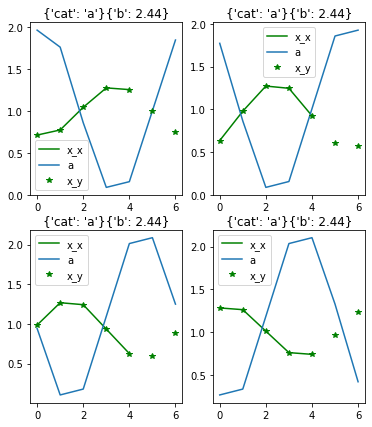

In [104]:
dl.show_batch(max_n = 4)

In [107]:
# hide
for o in dl:
    for a in o[:-1]:
        if a.shape[-1] > 0 and type(a) is TensorSeqs:
            test_close(a.mean(),0)
            test_close(a.std(),1,.1)
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti_)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()), TSMulti_)

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: NormalizeTSMulti is depricated. Please use `NormalizeSeqsMulti`


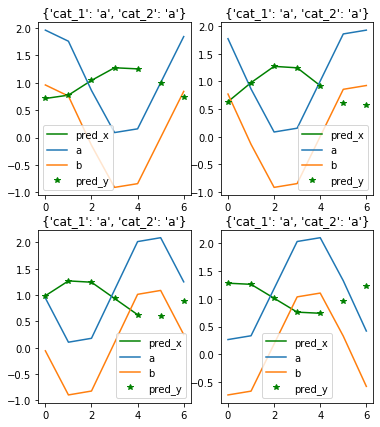

In [108]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[a for _ in range(1,5)],
                  'cat_1':[i for i in 'abbc'],'cat_2':[i for i in 'aabb']})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        for i in range(a.shape[0]):
            if a.shape[-1]>0 and type(a) is not TensorCatI:
                test_close(a[i].mean(),0)
                test_close(a[i].std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti_)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti_)

dl.show_batch(max_n = 4)

# TSDataLoaders

## Utils

In [13]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [14]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [15]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [16]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

,x,weather,city,cont
0,"[-1.4783384525723018, -1.4240868221838523, -1.6136560029173608, -1.5703763071681953, -1.6394281604986138, -1.5080329286398604, -1.6407020675475192, -1.5506139270850179, -1.2796478722768596, -1.3864282015016591, -1.0404515899904598, -1.0567946113703093, -0.8874416823506762, -0.7149783501655758, -0.6187640076950734, -0.2727276879186953, -0.5451346234265697, -0.38487492592167755, -0.2502984197922143, -0.21115810548520597, -0.3802156375488671, -0.4412852423835646, -0.3908629573629556, -0.696221653034824, -0.46543581066535766, -0.4913586958580071, -0.7832616355213236, -0.73679273437071, -0.4895...","[13.192539591888476, 13.052185658822392, 12.845445076236977, 12.595801538352676, 12.334784093747611, 12.092946148519243, 11.89128599205222, 11.735659439508716, 11.615834431689821, 11.509443258987911, 11.38961825116901, 11.233991698625506, 11.03233154215848, 10.790493596930098, 10.529476152325042, 10.27983261444073, 10.073092031855335, 9.932738098789248, 9.867434577467815, 9.868517705665685, 9.912503789162502, 9.967863779380055, 10.004044270220907, 10.000046972300419, 9.950016070456426, 9.864183623887808, 9.764917342202217, 9.679084895633592, 9.62905399378959, 9.625056695869105, 9.661237186...",adam,-0.199511
1,"[-2.442497633960548, -2.34587566574614, -2.1377491108681537, -1.977351306644492, -1.899047972058812, -1.709034805353743, -1.686083761666061, -1.423940123841227, -1.3626396621563701, -1.2661272074533405, -1.2129528099260642, -1.1951174397163742, -1.1198859788942275, -1.0701960472063496, -0.9158311787831961, -0.8818720252144413, -0.6374510524597976, -0.5051384661490185, -0.34837971698203124, -0.3349108425516317, -0.0909458041746632, -0.08706942177478819, -0.07307300112741666, -0.05242116620701835, -0.11361611174430714, -0.050900888692573976, 0.021545813851697234, 0.03222778194250637, 0.03942...","[-0.7090011635587998, -0.8690031508725897, -0.9740058637421758, -0.944562990966403, -0.7635009345785678, -0.4831944949575121, -0.20874955343048118, -0.06228293592620093, -0.13957181372944272, -0.47297312986306117, -1.0128541031822964, -1.6342954104931344, -2.168161744806375, -2.4480898116727476, -2.359814659181562, -1.878126797541234, -1.08002069075381, -0.12933993206658956, 0.7635224063742905, 1.3959819504601871, 1.626566593115905, 1.4121947514741344, 0.8189500689090303, 0.0034126424287918566, -0.8300129917269993, -1.4835618685828322, -1.8169631847164305, -1.780584158983174, -1.4221332146...",adam,-0.831751
2,"[-0.47399049141776367, -0.8620593361155051, -1.3107438957223605, -1.0589743757170584, -1.3733042111034675, -0.9025183623956589, -0.9389474021588238, -0.7437562636519461, 0.06922852884028799, 0.005871167490189263, 0.8363142708574055, 1.1687028406759024, 1.5058813971487726, 1.931987598351601, 2.098132854668203, 1.9678884114846704, 1.842169389902352, 1.3796338299328368, 1.038064548296246, 0.8094605666373197, 0.7038352455698252, 0.3437358701023316, 0.25813723004915545, -0.4726746699465776, -0.584099660148665, -0.6143895406387687, -0.39248385497651045, -0.06974467653388354, 0.28212521229183496,...","[1.0171144778514658, 0.9379147581950051, 0.858967864949747, 0.825360179970214, 0.8749108383765853, 1.0324871796895267, 1.3061280105270052, 1.6855159026213815, 2.1430199031202717, 2.6371797765642953, 3.1181696396952905, 3.534507719435449, 3.8401067082160676, 4.000709208332959, 3.998831934216982, 3.836540116890977, 3.535663341232855, 3.135406817630879, 2.6876616466763457, 2.25062684412552, 1.8815830461050358, 1.6297722622536235, 1.530324334564768, 1.6000307228706268, 1.835518741751634, 2.2140577759487554, 2.6968766472219583, 3.2345356765400117, 3.7736232903378575, 4.263872092886183, 4.664736...",adam,0.996369
3,"[2.692359927286532, 2.427513474249867, 2.153136361299251, 2.050578448968825, 1.8264637489865474, 1.7092049234754063, 1.5415089610695067, 1.376228685188565, 1.2740778138159847, 1.116073917311882, 0.9600045637878505, 0.7813141861562974, 0.6159212772665452, 0.43026037109994536, 0.37044382792052183, 0.237552579844554

In [17]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [18]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [19]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            make_ones = kwargs.pop('make_ones', True)
            kwargs.update({'after_batch':L(NormalizeTSMulti(make_ones=make_ones))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [20]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [21]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [22]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [23]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [24]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [26]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df.head(3)

,x,weather,city,cont
0,"[[0.3499817652112622, 0.22287298833808405, 0.3833310966032255, 0.0361281371909635, 0.3940890076512866, 0.3435985677698597, 0.48474513823414167, 0.6161005478047001, 0.9239871675999375, 0.819758379419906, 0.9236493473400123, 0.8275746904478541, 1.092983850981239, 1.1808712217206137, 1.2010371205071007, 1.5078615551290568, 1.712245632736618, 1.91173172939488, 2.2430523078542204, 2.2039242415853666, 1.9682861970526948, 1.9666998408834104, 1.7367915402528353, 1.451104221988865, 1.0408330283496683, 0.7913514946341493, 0.3360183672349563, 0.07195157773523013, -0.11095599151543348, -0.319359866531...","[[9.148751288601497, 8.913057444493193, 8.719020866899665, 8.658101400645753, 8.761692180812451, 8.987255326720362, 9.229453037992705, 9.353220172439837, 9.238743143126314, 8.824349547591561, 8.133612519225492, 7.277487402012668, 6.429702745277641, 5.781714768999325, 5.489871651136406, 5.630093954762371, 6.173519634124332, 6.990690115770793, 7.883672314439498, 8.637421869137905, 9.076081652995091, 9.108437664894538, 8.749862474928397, 8.114852954057016, 7.382720712990327, 6.746637474368401, 6.360838020823031, 6.3010147812536506, 6.54877479184693, 7.003747638982945, 7.518723571202935, 7.946...",adam,0.293366
1,"[[1.7730313448830919, 1.6160952842154572, 1.3482499989532435, 1.336950214647062, 1.2472297608842795, 1.2114779515601928, 1.2107482018137772, 1.2308461073077372, 1.421392393869819, 1.4243541169993865, 1.4552705782538644, 1.4691089170090665, 1.2944323177091897, 1.1469051379283983, 0.9271387058798399, 0.9010740051058557, 0.8825298105799287, 0.5793283387404403, 0.5768507847766191, 0.5751259877216753, 0.427656586139614, 0.28848298638865055, 0.07962140603833508, -0.3170323137334511, -0.38072470024151756, -0.6814049599853678, -0.8557054705420234, -1.035654598453132, -0.9376912498038924, -1.027457...","[[7.1823864683239576, 6.713028285106601, 6.37191857627651, 6.308754297122282, 6.603347810380141, 7.233618955076376, 8.072916852710613, 8.91859428528125, 9.544426121643486, 9.762199616319377, 9.474799868042057, 8.705302115906111, 7.593355818232023, 6.359529458260226, 5.247523520915066, 4.460532064155397, 4.109665396292236, 4.1887641180996695, 4.582206436906672, 5.102726815476994, 5.54765479922919, 5.756875627499357, 5.655683448510444, 5.270531000520408, 4.713987547853872, 4.144485981327103, 3.7138882371441864, 3.519309216571843, 3.5740244897895734, 3.8061768388052806, 4.085275734055544, 4.2...",adam,0.432122
2,"[[-2.4486849449937664, -2.2354714573727392, -2.0767913967064953, -1.9622972574703275, -1.9469247590351875, -1.8453721340418117, -1.5161792260882474, -1.4813609052500947, -1.3663229112755906, -1.2340623205069745, -1.0941751709018415, -0.9413369604794268, -0.8596501224331555, -0.6667447165066248, -0.5727183164651054, -0.4370001031439625, -0.3720590734626109, -0.29259195445720715, -0.17762875808616665, -0.04285483492146252, -0.01892461734142401, 0.02678721970221048, -0.057924197042005535, 0.067282905949809, 0.07027462350824722, 0.36043598003592053, 0.28163052687001205, 0.3305501409240203, 0.3...","[[7.637286759413509, 7.40077128100839, 7.195848080888238, 7.061474201817185, 7.026163478883017, 7.103538539698661, 7.289945440140781, 7.564471670437221, 7.891381291659334, 8.224651578151903, 8.514008332389599, 8.711650909760785, 8.778760907564665, 8.690913680657278, 8.44165607772851, 8.043757702298143, 7.527953777547868, 6.939333478910644, 6.331843145077061, 5.761626553704083, 5.28008037587367, 4.927540982920764, 4.7284338443418745, 4.688520285710174, 4.79459486904587, 5.016658074221996, 5.312257594532361, 5.632402065212902, 5.928242402894381, 6.157616197923765, 6.290573106156588, 6.313140...",adam,-0.028223


Train:130; Valid: 60; Test 10


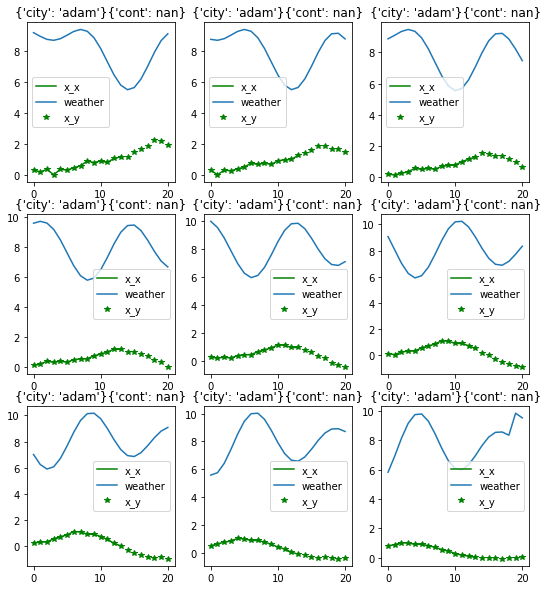

In [27]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=14, step=2, bs=32)
dbunch.train.show_batch(max_n=9)

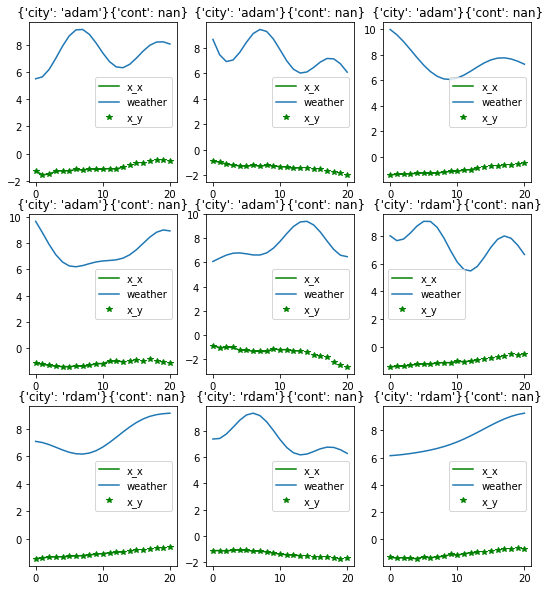

In [28]:
dbunch.test.show_batch(max_n=9)

# M5 Example

In [66]:
path = Path('../data/m5')
path.ls()

(#5) [Path('../data/m5/sales_train_validation.csv'),Path('../data/m5/sample_submission.csv'),Path('../data/m5/calendar.csv'),Path('../data/m5/m5-forecasting-accuracy.zip'),Path('../data/m5/sell_prices.csv')]

In [109]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:1000,:]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [110]:
def _to_series(df):
    r = L()
    for i in range(df.shape[0]):
        r.append(pd.Series(df.iloc[i,6:]))
    return r

def to_contained_series(df):    
    data={k:v for k,v in dict(df).items() if 'd_' not in k}
    data['sales'] = _to_series(df)
    df = pd.DataFrame(data=data)
    return df
df_sales = to_contained_series(df_sales)
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 2, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 3, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 3, ...)"
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
...,...,...,...,...,...,...,...
995,HOUSEHOLD_1_440_CA_1_validation,HOUSEHOLD_1_440,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,"(0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 1, 3, 2, 2, 1, 0, 2, 1, 2, 0, 5, 2, 0, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 4, 3, 1, 1, 1, 4, 2, 2, 4, 3, 1, 1, 4, 5, 11, 2, 2, 0, 3, 2, 7, 7, 2, 3, 0, 0, 5, 7, 9, 5, 3, 4, 4, 0, 5, 3, 4, 3, 1, 2, 3, 3, 9, 4, 3, 2, 1, 5, 0, 8, 3, 3, 3, 3, 5, 3, 4, 3, 3, 0, 2, 4, 3, 7, ...)"
996,HOUSEHOLD_1_441_CA_1_validation,HOUSEHOLD_1_441,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
997,HOUSEHOLD_1_442_CA_1_validation,HOUSEHOLD_1_442,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...)"
998,HOUSEHOLD_1_443_CA_1_validation,HOUSEHOLD_1_443,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 2, 3, 6, 0, 0, 0, 0, 1, 0, 0, 0, 2, 4, 2, 1, 2, 8, 0, 0, 0, 0, 0, 0, 0, 8, 3, 5, 3, 2, 1, 2, 5, 2, 1, 2, 7, 3, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, ...)"


In [111]:
dbunch =  DfDataLoaders.from_df(df_sales, 'sales', horizon = 28, lookback=28*3, step=2)
dbunch.train.show_batch(max_n=9)

Exception: <class 'str'>

In [107]:
df_prices = pd.read_csv(path / 'sell_prices.csv')
df_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [106]:
df_cal = pd.read_csv(path / 'calendar.csv')
df_cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [40]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
